In [1]:
!pip install -q pyro-ppl torch
import numpy as np
import torch
from torch.distributions import constraints
import matplotlib.pyplot as plt

import pyro
from pyro.distributions import Normal, Gamma, MultivariateNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.optim as optim

You should consider upgrading via the 'pip install --upgrade pip' command.


## Generate some data

In [2]:
# Sample data
np.random.seed(123)
N = 100
correct_mean = 5
correct_precision = 1
data = torch.tensor(np.random.normal(loc=correct_mean, scale=np.sqrt(1./correct_precision), size=N), dtype=torch.float)


## Our model specification

In [3]:
# Fill the method with code to define a simple Gaussian model with mean \mu and precision \gamma
def model(data):
    #Define the prior for \mu and \gamma

    #Consider a plate constrcut
    with pyro.plate("data", len(data)):
        #Define the distribution over x given \mu and \gamma.
        #Observe x with data
   

## Our guide specification

In [4]:
# Define the right guide for the above model, including the variational parameters. 
def guide(data=None):
    #Define a q(\mu; a,b) where a and b are Pyro's parameters
    
    #Define a q(\gamma; c,d) where c and d are Pyro's parameters


## Do learning

In [5]:
# setup the optimizer
adam_args = {"lr": 0.01}
optimizer = Adam(adam_args)

pyro.clear_param_store()
svi = SVI(model, guide, optimizer, loss=Trace_ELBO(), num_samples=10)
train_elbo = []
# training loop
for epoch in range(3000):
    loss = svi.step(data)
    train_elbo.append(-loss)
    if (epoch % 500) == 0:
        print("[epoch %03d] average training loss: %.4f" % (epoch, loss))

[epoch 000] average training loss: 954.2028
[epoch 500] average training loss: 334.2425
[epoch 1000] average training loss: 275.4371
[epoch 1500] average training loss: 173.1832
[epoch 2000] average training loss: 169.1556
[epoch 2500] average training loss: 176.9451


In [6]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

rate tensor(3.8607, grad_fn=<AddBackward0>)
conc tensor(4.7952, grad_fn=<AddBackward0>)
mu_mean tensor(5.0331, requires_grad=True)
mu_scale tensor(0.1595, grad_fn=<AddBackward0>)


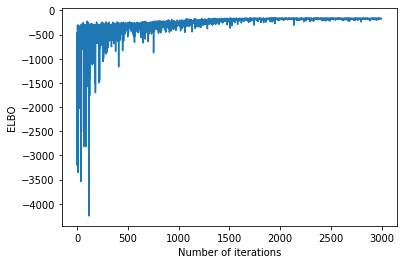

In [7]:
plt.plot(range(len(train_elbo)), train_elbo)
plt.xlabel("Number of iterations")
plt.ylabel("ELBO")
plt.show()

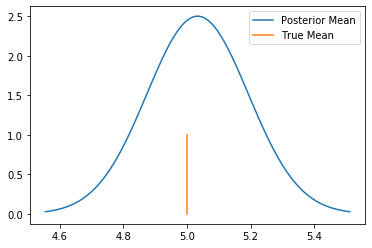

In [8]:
import scipy.stats as stats

mu = pyro.param("mu_mean").item()
scale = pyro.param("mu_scale").item()
x = np.linspace(mu - 3*scale, mu + 3*scale, 100)
plt.plot(x, stats.norm.pdf(x, mu, scale), label='Posterior Mean')
plt.plot([correct_mean, correct_mean],[0., 1.], label='True Mean')
plt.legend()
plt.show()

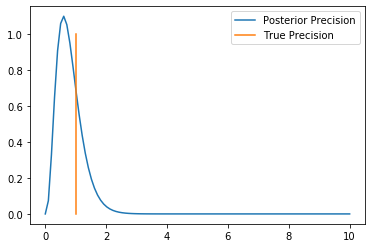

In [9]:
import scipy.stats as stats

rate = pyro.param("rate").item()
conc = pyro.param("conc").item()
x = np.linspace(0, 10, 100)
gamma = Gamma(rate, conc)
plt.plot(x, np.exp(gamma.log_prob(torch.Tensor(x)).numpy()), label='Posterior Precision')
plt.plot([correct_precision, correct_precision],[0., 1.], label='True Precision')
plt.legend()
plt.show()